In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # 시각화 라이브러리


### 목표
- 타이타닉 데이터를 학습해서 생존자 및 사망자를 예측해보자
- 머신러닝 전체 과정 진행

### 1. 문제정의
- 생존자/사망자 예측
- 머신러닝 과정 전체를 체험해보는 예제

### 2. 데이터 수집
- kaggle 사이트로부터 다운로드

In [144]:
train = pd.read_csv('./data/train.csv', index_col='PassengerId')
test = pd.read_csv('./data/test.csv', index_col='PassengerId')
#data = pd.read_csv('./data/gender_submission.csv')


In [145]:
train.shape

(891, 11)

In [146]:
test.shape

(418, 10)

### 3. 데이터 전처리 및 데이터탐색

In [147]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


### Age 채우기 - 상관관계 이용해서 채움
- 단순 기술통계치로 채우지않고 다른 컬럼과의 상관관계를 통해 결측치를 채워보자.
- Age와 다른 컬럼간의 상관관계를 알아보자.

In [148]:
# corr()             
# 상관계수(correlation) : 변수간의 관계의 정도를 수치로 요약해주는 지표
# -1 ~ 1 사이의 값으로 표현
# -1에 가까울수록 음의 상관관계
# 1에 가까울수록 양의 상관관계
train.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


- Pclass가 가장 높은 상관관계를 갖는다. (음의 상관관계 : 반비례)
- 생존에 관련이 많은 것 같은 성별을 함께 활용

In [149]:
pt1 = train.pivot_table( values='Age',
                 index = ['Pclass', 'Sex'],
                 aggfunc = 'mean')
pt1

Age
Pclass Sex              
1      female  34.611765
       male    41.281386
2      female  28.722973
       male    30.740707
3      female  21.750000
       male    26.507589

In [150]:
pt1.loc[1, 'female'][0]

34.61176470588235

In [151]:
pt1.loc[3, 'male'][0]

26.507588932806325

In [152]:
def fill_age(row):
    # 만약 나이가 결측치라면 피봇테이블에서 값을 가져와서 채우겠다.
    if np.isnan(row['Age']):
        return pt1.loc[row['Pclass'], row['Sex']][0]
    # 만약 나이가 결측치가 아니라면 원래 나이값을 사용
    else:
        return row['Age']

In [153]:
train['Age'] = train.apply(fill_age, axis = 1)

In [154]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [155]:
test['Age'] = test.apply(fill_age, axis = 1)

In [156]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


### Embarked 채우기 - fillna로 가장 많은 값 넣어서 채워줌

In [157]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [158]:
test['Embarked'].value_counts()

S    270
C    102
Q     46
Name: Embarked, dtype: int64

In [159]:
# fillna('값') : 결측치에 값을 채움

In [160]:
train['Embarked'] = train['Embarked'].fillna('S')

In [161]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [162]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


### Fare 채우기

In [163]:
# 1. 상관관계 파악하여 가장 관계가 깊은 컬럼 찾기 / test 결측치 채우기 위해 신뢰도 있는 data (양 많음) 사용
train.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.067485,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.407015,0.083081,0.018443,-0.549500
Age,-0.067485,-0.407015,1.000000,-0.251313,-0.180705,0.118308
SibSp,-0.035322,0.083081,-0.251313,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.180705,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.118308,0.159651,0.216225,1.000000


In [164]:
# 2. 관계가 깊은 컬럼과 성별을 같이 묶어 피봇 테이블 생성
pt2 = train.pivot_table( values='Fare',
                 index = ['Pclass', 'Sex'],
                 aggfunc = 'mean')
pt2

Fare
Pclass Sex               
1      female  106.125798
       male     67.226127
2      female   21.970121
       male     19.741782
3      female   16.118810
       male     12.661633

In [165]:
pt2.loc[2, 'female']

Fare    21.970121
Name: (2, female), dtype: float64

In [166]:
# 3. apply 함수 활용할 사용자 정의함수 구현 ( fill_fare() 로 만들기 )
def fill_Fare(row):
    # 만약 나이가 결측치라면 피봇테이블에서 값을 가져와서 채우겠다.
    if np.isnan(row['Fare']):
        return pt2.loc[row['Pclass'], row['Sex']][0]
    # 만약 나이가 결측치가 아니라면 원래 나이값을 사용
    else:
        return row['Fare']

In [167]:
# 4. apply 함수 사용하여 결측치 채우기
test['Fare'] = test.apply(fill_Fare, axis = 1)

In [168]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      418 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


In [169]:
train['Fare'].value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
35.0000     1
28.5000     1
6.2375      1
14.0000     1
10.5167     1
Name: Fare, Length: 248, dtype: int64

In [170]:
test['Fare'].value_counts()

7.7500     21
26.0000    19
8.0500     17
13.0000    17
10.5000    11
           ..
8.7125      1
7.8208      1
8.5167      1
78.8500     1
22.3583     1
Name: Fare, Length: 170, dtype: int64

In [171]:
# 결측치가 적을 때는 굳이 apply 함수 사용해서 채우지 말고  .fillna 이용해서 채워도 됨

### Cabin 결측치 채우기

In [172]:
train['Cabin']

PassengerId
1       NaN
2       C85
3       NaN
4      C123
5       NaN
       ... 
887     NaN
888     B42
889     NaN
890    C148
891     NaN
Name: Cabin, Length: 891, dtype: object

In [173]:
train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

- Cabin의 범주가 너무 많으니 종류 줄여보자 ! (모델이 복잡해지는 것 (과대적합) 방지)
- 결측치를 하나의 데이터로 활용

In [174]:
train['Cabin'] = train['Cabin'].str[0]

In [175]:
train['Cabin']

PassengerId
1      NaN
2        C
3      NaN
4        C
5      NaN
      ... 
887    NaN
888      B
889    NaN
890      C
891    NaN
Name: Cabin, Length: 891, dtype: object

In [176]:
train['Cabin'].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [177]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [178]:
# 결측치 채우기

train['Cabin'].fillna('M', inplace=True)

In [179]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     891 non-null    object 
 10  Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [180]:
test['Cabin'] = test['Cabin'].str[0]

In [181]:
test['Cabin'].str[0]

PassengerId
892     NaN
893     NaN
894     NaN
895     NaN
896     NaN
       ... 
1305    NaN
1306      C
1307    NaN
1308    NaN
1309    NaN
Name: Cabin, Length: 418, dtype: object

In [182]:
test['Cabin'].fillna('M', inplace=True)

In [183]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      418 non-null    float64
 8   Cabin     418 non-null    object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


### 4. 탐색적 데이터 분석 (EDA)
- train 데이터 이용해 탐색

#### 범주형 데이터 시각화
- 빈도 기반의 bar chart 많이 활용 

##### Cabin 시각화

<AxesSubplot:xlabel='Cabin', ylabel='count'>

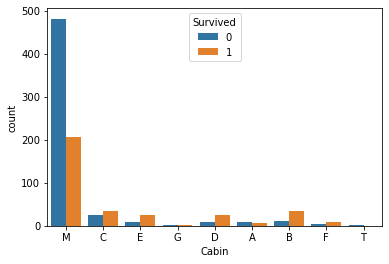

In [184]:
sns.countplot(data=train, x='Cabin',
             hue='Survived')

- M에서 상대적으로 많은 사람들이 사망했다. 모델에게 학습을 시켜도 의미가 있을 수 있겠다

##### Pclass 시각화

<AxesSubplot:xlabel='count', ylabel='Pclass'>

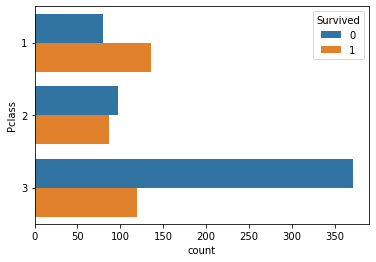

In [185]:
sns.countplot(data=train,
             y='Pclass' ,
             hue = 'Survived')

- 1등급에 탑승하면 생존 확률이 조금 있다
- 3등급에 탑승하면 사망 확률이 높다
- Pclass를 모델에게 사용해도 괜찮을 것 같다 

##### Pclass와 Cabin 시각화

<AxesSubplot:xlabel='Cabin', ylabel='count'>

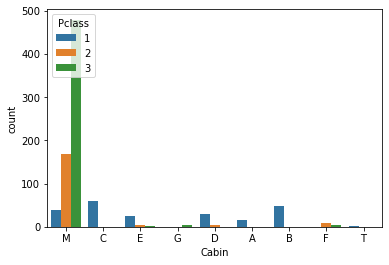

In [186]:
sns.countplot(data=train,
             x='Cabin',
             hue='Pclass')

- A,B,C에는 1등급 사람들이 탑승했다
- M에는 3등급 사람들이 많이 탑승했다 - > 3 등급 사람이 많이 사망해서 정보가 손실된걸까?

##### Embarked, Sex 시각화

<AxesSubplot:xlabel='Embarked', ylabel='count'>

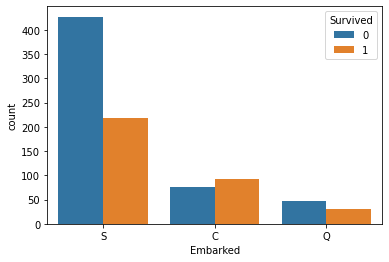

In [187]:
sns.countplot(data=train,
             x='Embarked',
             hue='Survived')

<AxesSubplot:xlabel='Embarked', ylabel='count'>

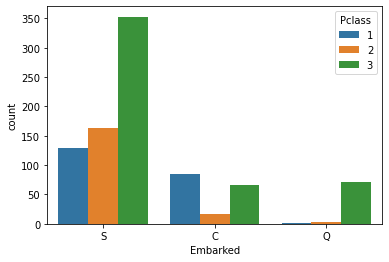

In [188]:
sns.countplot(data=train,
             x='Embarked',
             hue='Pclass')

<AxesSubplot:xlabel='Sex', ylabel='count'>

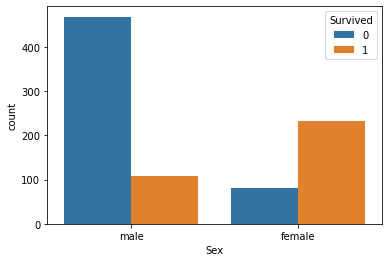

In [189]:
sns.countplot(data=train,
             x='Sex',
             hue='Survived')

#### 수치형 데이터

In [190]:
train['Age'] = train['Age'].astype('int')

In [191]:
test['Age'] = test['Age'].astype('int')

In [192]:
test['Age']

PassengerId
892     34
893     47
894     62
895     27
896     22
        ..
1305    26
1306    39
1307    38
1308    26
1309    26
Name: Age, Length: 418, dtype: int32

In [193]:
train['Age']

PassengerId
1      22
2      38
3      26
4      35
5      35
       ..
887    27
888    19
889    21
890    26
891    32
Name: Age, Length: 891, dtype: int32

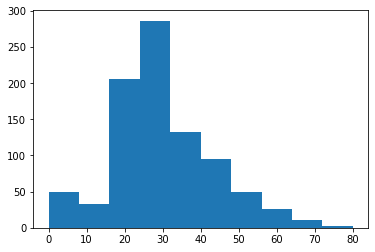

In [194]:
plt.hist(train['Age']) 
plt.show()

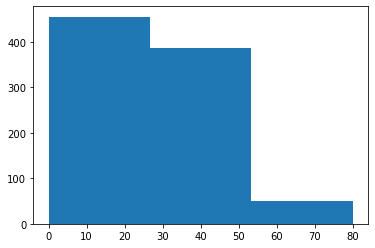

In [195]:
plt.hist(train['Age'], bins=3) 
plt.show()

<AxesSubplot:xlabel='Sex', ylabel='Age'>

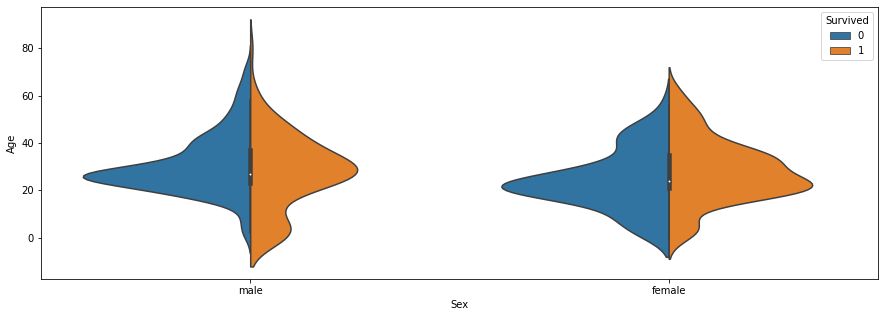

In [196]:
# 밀도 그래프
plt.figure(figsize=(15,5))
sns.violinplot(data=train,
              y='Age',
              x='Sex',
              hue='Survived',
              split=True)

In [197]:
# 가운데는 4분위수를 나타낸 것이다 흰 점이 중앙값 ???????????

In [198]:
# 남자 어린아이는 생존 확률이 더 높고 여자 어린 아이는 사망 확률이 더 높다 (시대적 배경??)
# 남성의 경우 2-30대가 좀 더 사망
# 노인의 경우는 남자는 사망 확률이, 여자는 생존 확률이 더 높다

##### Fare 시각화

<AxesSubplot:xlabel='Sex', ylabel='Fare'>

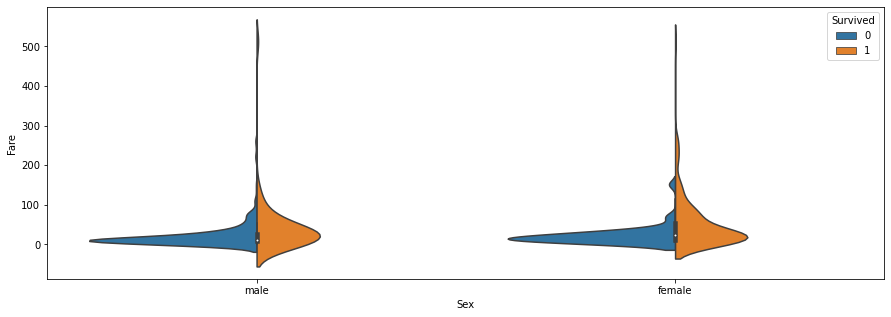

In [199]:
# 밀도 그래프
plt.figure(figsize=(15,5))
sns.violinplot(data=train,
              y='Fare',
              x='Sex',
              hue='Survived',
              split=True)

- 낮은 요금을 지불한 사람들이 상대적으로 많이 사망했다.
- 전체 요금이 0~40 달러 사이에 많이 분포되어 있다.

In [200]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,M,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,M,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,M,S


### 특성공학
- SibSp와 ParCh를 합쳐 '가족'이라는 새 컬럼 생성

In [201]:
train['Family_Size'] = train['SibSp'] + train['Parch'] + 1

In [202]:
test['Family_Size'] = test['SibSp'] + test['Parch'] + 1

In [203]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,M,S,2
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,C,2
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,M,S,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C,S,2
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,M,S,1


<AxesSubplot:xlabel='Family_Size', ylabel='count'>

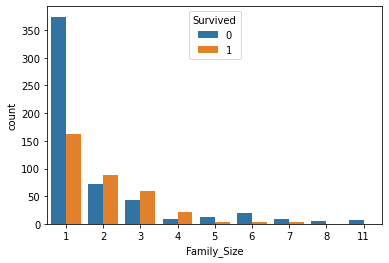

In [204]:
sns.countplot(data=train,
             x='Family_Size',
             hue='Survived')

- 1명은 사망 비율 높다
- 2~4명은 생존 비율이 조금 더 높다
- 5명 이상은 사망 비율이 좀 더 높다
- Family_Size를 그대로 써도 좋지만, 범주형 데이터로 변환해보자
- Binning (수치형 -> 범주형) - 모델 학습의 단순화 유도

In [205]:
# 수치 data를 범주 data로 바꾸는 작업 - binning  
# 연속적인 수치를 좀 더 단순화시키기 위함

##### 특성공학
- Family_Size가 1이면 Alone, 2-4이면 small, 5명 이상이면 Large 범주로 변경
- cut 함수 활용 

In [206]:
bins= [0, 1, 4, 20]
labels= [ 'Alone', 'Small', 'Large' ]
train['Family_Group'] = pd.cut(x=train['Family_Size'],
      bins=bins,
      labels=labels)

In [207]:
train.head(1)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Family_Group
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,M,S,2,Small


In [208]:
bins= [0, 1, 4, 20]
labels= [ 'Alone', 'Small', 'Large' ]
test['Family_Group'] = pd.cut(x=test['Family_Size'],
      bins=bins,
      labels=labels)

In [209]:
test.head(3)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Family_Group
PassengerId,,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34,0,0,330911,7.8292,M,Q,1,Alone
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47,1,0,363272,7.0000,M,S,2,Small
894,2,"Myles, Mr. Thomas Francis",male,62,0,0,240276,9.6875,M,Q,1,Alone


<AxesSubplot:xlabel='Family_Group', ylabel='count'>

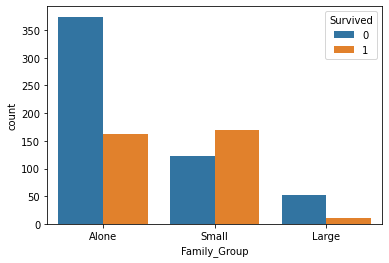

In [210]:
sns.countplot(data=train,
             x='Family_Group',
             hue='Survived')

In [211]:
train.head(1)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Family_Group
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,M,S,2,Small


##### 특성 공학
- text 데이터 다루기 ( 비정형 데이터 )
- Name : 중간에 있는 호칭 정보만 뽑아서 정형화 시켜보자 !

In [212]:
train['Name']

PassengerId
1                                Braund, Mr. Owen Harris
2      Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                 Heikkinen, Miss. Laina
4           Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                               Allen, Mr. William Henry
                             ...                        
887                                Montvila, Rev. Juozas
888                         Graham, Miss. Margaret Edith
889             Johnston, Miss. Catherine Helen "Carrie"
890                                Behr, Mr. Karl Howell
891                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [213]:
# 호칭을 뽑아보자
# 1. 쉼표 (,) 뒤 

'Braund, Mr. Owen Harris'.split(',')

['Braund', ' Mr. Owen Harris']

In [214]:
# 2. '.' 앞에 호칭 정보가 있다 
'Braund, Mr. Owen Harris'.split(',')[1].split('.')

[' Mr', ' Owen Harris']

In [215]:
'Braund, Mr. Owen Harris'.split(',')[1].split('.')[0]

' Mr'

In [216]:
# 3. 공백 제거 !
'Braund, Mr. Owen Harris'.split(',')[1].split('.')[0].strip()

'Mr'

In [217]:
# 함수 만들기

def split_title(row) :
    return row.split(',')[1].split('.')[0].strip()

In [218]:
# 호칭 정보가 담긴 Title 컬럼 
train['Title'] = train['Name'].apply(split_title)
test['Title'] = test['Name'].apply(split_title)

In [219]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Family_Group,Title
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,M,S,2,Small,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,C,2,Small,Mrs
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,M,S,1,Alone,Miss
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C,S,2,Small,Mrs
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,M,S,1,Alone,Mr


In [220]:
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Family_Group,Title
PassengerId,,,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34,0,0,330911,7.8292,M,Q,1,Alone,Mr
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47,1,0,363272,7.0000,M,S,2,Small,Mrs
894,2,"Myles, Mr. Thomas Francis",male,62,0,0,240276,9.6875,M,Q,1,Alone,Mr
895,3,"Wirz, Mr. Albert",male,27,0,0,315154,8.6625,M,S,1,Alone,Mr
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22,1,1,3101298,12.2875,M,S,3,Small,Mrs


In [221]:
train['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

<AxesSubplot:xlabel='Title', ylabel='count'>

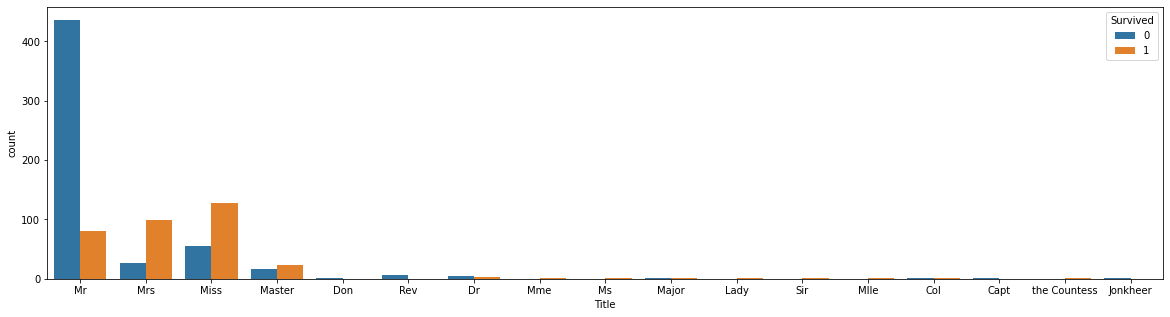

In [222]:
plt.figure(figsize=(20,5))
sns.countplot(data=train,
             x='Title',
             hue="Survived")

(0.0, 15.0)

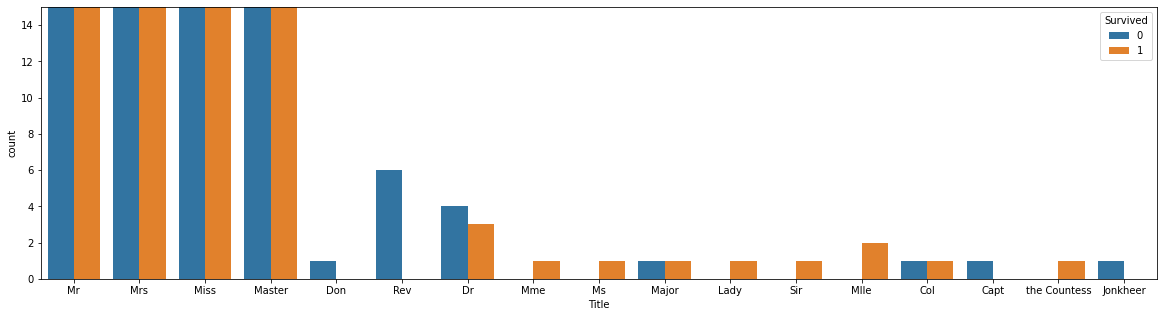

In [223]:
plt.figure(figsize=(20,5))
sns.countplot(data=train,
             x='Title',
             hue="Survived")
plt.ylim(0,15)

- Mr, Mrs, Miss : 성별과 관련이 많은 호칭 , 모델에 사용해봐도 괜찮겠다
- Master : 나이가 어린 남성을 부르는 호칭
- 나머지 호칭들은 인원수 적고 종류가 많다 -> 범주 통합시켜보자 

In [224]:
# map 함수 이용 
title_dic = {
    'Mr' : 'Mr',
    'Mrs' : 'Mrs',
    'Miss' : 'Miss',
    'Master' : 'Master',
    'Mme' : 'Miss',
    'Lady' : 'Miss',
    'Don' : 'Other',
    'Rev' : 'Other',
    'Dr' : 'Other',
    'Ms' : 'Miss',
    'Major' : 'Other',
    'Sir' : 'Other',
    'Mlle' : 'Other',
    'Col' : 'Other',
    'Capt' : 'Other',
    'the Countess' : 'Other',
    'Jonkheer' : 'Other',
    'Dona': 'Other'
}

In [225]:
train['Title2']=train['Title'].map(title_dic)

In [226]:
train['Title2'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], dtype=object)

In [227]:
test['Title2']=test['Title'].map(title_dic)

In [228]:
test['Title2'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], dtype=object)

In [229]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Family_Group,Title,Title2
PassengerId,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,M,S,2,Small,Mr,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,C,2,Small,Mrs,Mrs
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,M,S,1,Alone,Miss,Miss
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C,S,2,Small,Mrs,Mrs
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,M,S,1,Alone,Mr,Mr


#### Ticket 정보는 사용하지 않을거다 !

#### 사용하지 않을 컬럼 정리

In [230]:
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Family_Size', 'Family_Group', 'Title',
       'Title2'],
      dtype='object')

In [231]:
train.drop(['Name', 'Ticket', 'Title'], axis=1, inplace=True)
test.drop(['Name', 'Ticket', 'Title'], axis=1, inplace=True)

In [232]:
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family_Size,Family_Group,Title2
PassengerId,,,,,,,,,,,,
1,0,3,male,22,1,0,7.2500,M,S,2,Small,Mr
2,1,1,female,38,1,0,71.2833,C,C,2,Small,Mrs
3,1,3,female,26,0,0,7.9250,M,S,1,Alone,Miss
4,1,1,female,35,1,0,53.1000,C,S,2,Small,Mrs
5,0,3,male,35,0,0,8.0500,M,S,1,Alone,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,male,27,0,0,13.0000,M,S,1,Alone,Other
888,1,1,female,19,0,0,30.0000,B,S,1,Alone,Miss
889,0,3,female,21,1,2,23.4500,M,S,4,Small,Miss


### 5. 모델링

- 인코딩 (문자 형태의 데이터를 숫자 형태의 데이터로 변환)
    - 1. label encoding
    - 2. one-hot encoding
- 모델 선택 및 하이퍼 파라미터 조정
- 모델 학습
- 모델 평가

In [233]:
# 원-핫 인코딩
train = pd.get_dummies(train)

In [234]:
test = pd.get_dummies(test)

In [235]:
train.shape

(891, 29)

In [236]:
test.shape

(418, 27)

In [237]:
#categorical_features = ['Sex', 'Cabin', 'Embarked', 'Family_Group', 'Title2']

In [238]:
#categorical_features

In [239]:
#pd.get_dummies(test['Sex'], prefix='Sex') # 이런식으로 하나씩 원핫 인코딩 시킨 후 다시 담아줌 

In [240]:
#for feature_name in categorical_features :
#    one_hot = pd.get_dummies(test[feature_name], prefix=feature_name) # 원핫인코딩
#    test.drop(feature_name, axis=1, inplace=True) # 기존 글자 형태 데이터 삭제
#    test = pd.concat([test, one_hot], axis=1) # 기존 데이터에 원-핫 데이터 병합

In [241]:
# 위에서 인덱싱 (sex[0]) 해주면서 시리즈가 아니라 정수만 리턴돼 get_dummies 원 핫 인코딩이 가능함 
# 이제 for문 사용해서 넣어주지 않고 pd.get_dummies(test) 로 한 번에 가능함 

In [242]:
# train, test 컬럼명 차집합 연산
# train에는 test에는 없는 범주 데이터가 하나 더 있었음
# set (집합)

set(train.columns) - set(test.columns)

{'Cabin_T', 'Survived'}

In [243]:
# test에 Cabin_T 라는 컬럼을 만들되 모든 데이터를 0으로 만들어서 넣어줌 
test['Cabin_T'] = 0

In [244]:
test.head(1)

,Pclass,Age,SibSp,Parch,Fare,Family_Size,Sex_female,Sex_male,Cabin_A,Cabin_B,...,Embarked_S,Family_Group_Alone,Family_Group_Small,Family_Group_Large,Title2_Master,Title2_Miss,Title2_Mr,Title2_Mrs,Title2_Other,Cabin_T
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,3,34,0,0,7.8292,1,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0


In [245]:
# 컬럼 확인
train.columns

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family_Size',
       'Sex_female', 'Sex_male', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D',
       'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_M', 'Cabin_T', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Family_Group_Alone', 'Family_Group_Small',
       'Family_Group_Large', 'Title2_Master', 'Title2_Miss', 'Title2_Mr',
       'Title2_Mrs', 'Title2_Other'],
      dtype='object')

In [246]:
test.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family_Size', 'Sex_female',
       'Sex_male', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin_M', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Family_Group_Alone', 'Family_Group_Small',
       'Family_Group_Large', 'Title2_Master', 'Title2_Miss', 'Title2_Mr',
       'Title2_Mrs', 'Title2_Other', 'Cabin_T'],
      dtype='object')

In [247]:
test.shape

(418, 28)

### 문제, 정답 나누기

In [248]:
X_train = train.drop('Survived', axis=1)
y_train = train['Survived']

In [249]:
X_test = test
# y_test (정답) -> 케글한테

In [250]:
train.drop('Survived', axis=1) # test에는 Survived가 없으므로 drop 해 줌

,Pclass,Age,SibSp,Parch,Fare,Family_Size,Sex_female,Sex_male,Cabin_A,Cabin_B,...,Embarked_Q,Embarked_S,Family_Group_Alone,Family_Group_Small,Family_Group_Large,Title2_Master,Title2_Miss,Title2_Mr,Title2_Mrs,Title2_Other
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,3,22,1,0,7.2500,2,0,1,0,0,...,0,1,0,1,0,0,0,1,0,0
2,1,38,1,0,71.2833,2,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,3,26,0,0,7.9250,1,1,0,0,0,...,0,1,1,0,0,0,1,0,0,0
4,1,35,1,0,53.1000,2,1,0,0,0,...,0,1,0,1,0,0,0,0,1,0
5,3,35,0,0,8.0500,1,0,1,0,0,...,0,1,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,2,27,0,0,13.0000,1,0,1,0,0,...,0,1,1,0,0,0,0,0,0,1
888,1,19,0,0,30.0000,1,1,0,0,1,...,0,1,1,0,0,0,1,0,0,0
889,3,21,1,2,23.4500,4,1,0,0,0,...,0,1,0,1,0,0,1,0,0,0


In [251]:
# 컬럼 확인 ( 순서 다른 것을 고쳐주기 위해 확인해봄)
X_train.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family_Size', 'Sex_female',
       'Sex_male', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin_M', 'Cabin_T', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Family_Group_Alone', 'Family_Group_Small',
       'Family_Group_Large', 'Title2_Master', 'Title2_Miss', 'Title2_Mr',
       'Title2_Mrs', 'Title2_Other'],
      dtype='object')

In [252]:
X_test.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family_Size', 'Sex_female',
       'Sex_male', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin_M', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Family_Group_Alone', 'Family_Group_Small',
       'Family_Group_Large', 'Title2_Master', 'Title2_Miss', 'Title2_Mr',
       'Title2_Mrs', 'Title2_Other', 'Cabin_T'],
      dtype='object')

In [253]:
X_test = X_test[X_train.columns] #  X_test를 X_train 컬럼 순서대로 가져오겠다

In [254]:
X_train.head(1)

,Pclass,Age,SibSp,Parch,Fare,Family_Size,Sex_female,Sex_male,Cabin_A,Cabin_B,...,Embarked_Q,Embarked_S,Family_Group_Alone,Family_Group_Small,Family_Group_Large,Title2_Master,Title2_Miss,Title2_Mr,Title2_Mrs,Title2_Other
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,3,22,1,0,7.25,2,0,1,0,0,...,0,1,0,1,0,0,0,1,0,0


In [255]:
X_test.head(1)

,Pclass,Age,SibSp,Parch,Fare,Family_Size,Sex_female,Sex_male,Cabin_A,Cabin_B,...,Embarked_Q,Embarked_S,Family_Group_Alone,Family_Group_Small,Family_Group_Large,Title2_Master,Title2_Miss,Title2_Mr,Title2_Mrs,Title2_Other
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,3,34,0,0,7.8292,1,0,1,0,0,...,1,0,1,0,0,0,0,1,0,0


In [256]:
# Cross Validation 

In [257]:
X_train.shape

(891, 28)

In [258]:
X_test.shape

(418, 28)

### 5. 모델 선택 및 하이퍼 파라미터 튜닝
- Decision Tree(max_depth, max_features, max_nodes, min_sample_leaf)
- 어떤 모델을 선택해야 데이터들이 더 나은 쪽으로 가는지 분석할거

In [259]:
from sklearn.tree import DecisionTreeClassifier
# 분류모델 DecisionTreeClassifier 

In [272]:
tree_model = DecisionTreeClassifier(max_depth = 4)

In [261]:
# train에는 있고 test에는 없는 컬럼 찾기
# 1
set(X_train.columns) - set(X_test.columns)

set()

In [262]:
# test에는 있고 train에는 없는 컬럼 찾기
# 2
set(X_test.columns) - set(X_train.columns)

set()

In [263]:
# max_depth
# 교차 검증

from sklearn.model_selection import cross_val_score



In [264]:

for md in range(1,50):
    t_model = DecisionTreeClassifier(max_depth = md)


    # 학습할 모델, 훈련용 문제, 훈련용 정답, 몇겹
    result = cross_val_score(t_model, X_train, y_train, cv = 5 ).mean()
    print('max_depth : ' ,md, ', score : ', result)

max_depth :  1 , score :  0.7788964911179461
max_depth :  2 , score :  0.7834285355596007
max_depth :  3 , score :  0.8192768815516918
max_depth :  4 , score :  0.8282656455966355
max_depth :  5 , score :  0.8092272926997677
max_depth :  6 , score :  0.8091833532107211
max_depth :  7 , score :  0.7968802962776975
max_depth :  8 , score :  0.8047329106772958
max_depth :  9 , score :  0.7968426338585148
max_depth :  10 , score :  0.8136902893729208
max_depth :  11 , score :  0.8058251208335948
max_depth :  12 , score :  0.7923670830456343
max_depth :  13 , score :  0.7957315924926244
max_depth :  14 , score :  0.7946142740568702
max_depth :  15 , score :  0.7912497646098802
max_depth :  16 , score :  0.78788525516289
max_depth :  17 , score :  0.7923670830456343
max_depth :  18 , score :  0.7901324461741259
max_depth :  19 , score :  0.7934906785512522
max_depth :  20 , score :  0.789008850668508
max_depth :  21 , score :  0.7890214048082356
max_depth :  22 , score :  0.7957378695624883


In [265]:
# 최적의 max_depth = 4번째꺼일 확률이 가장 높음   --> 이제 이걸 활용해서 모델을 만들면됨

- 테스트세트에 과대적합이 발생할때
    - 하이퍼파라미터 튜닝을 하며 여러번 test세트에 확인을 할때
    - 모델이 test세트(고정되어있는)에 과대적합
        -> 그러면 test데이터의 변화가 일어나면 예측을 잘 하지 못함.
            -> 여기서 우리가 해줄 수 있는건 1. train과 test사이에 검증이라는 새로운 데이터를 집어넣는 방법(검증)과
            -> 2. train, test데이터에 학습할때마다 계속적인 변화를 주기 (교차검증)

- 교차검증 해주면 좋다 -->  과대적합이 많이 예방된다. / 예측에 대한 신뢰도 상승 
- 교차검증 = 학습-평가 데이터 나누기를 여러번 반복하여 일반화 에러를 평가하는 방법

- 교차검증 중에 이방법을 사용할거임
- k-fold cross-validation 동작방법
- 1. 데이터 셋을 k개로 나눈다.
- 2. 첫 번째 세트를 제외하고 나머지에 대해 모델을 학습한다. 그리고 첫 번째 세트를 이용해서 평가를 수행한다.
- 3. 2번 과정을 마지막 세트까지 반복한다.
- 4. 각 세트에 대해 구했던 평가 결과의 평균을 구한다. 

### 6. 학습
- fit


In [273]:
tree_model.fit(X_train,y_train)
# tree_model.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=4)

### 7. 예측
- predict
- score

In [267]:
X_test.head()

,Pclass,Age,SibSp,Parch,Fare,Family_Size,Sex_female,Sex_male,Cabin_A,Cabin_B,...,Embarked_Q,Embarked_S,Family_Group_Alone,Family_Group_Small,Family_Group_Large,Title2_Master,Title2_Miss,Title2_Mr,Title2_Mrs,Title2_Other
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,3,34,0,0,7.8292,1,0,1,0,0,...,1,0,1,0,0,0,0,1,0,0
893,3,47,1,0,7.0000,2,1,0,0,0,...,0,1,0,1,0,0,0,0,1,0
894,2,62,0,0,9.6875,1,0,1,0,0,...,1,0,1,0,0,0,0,1,0,0
895,3,27,0,0,8.6625,1,0,1,0,0,...,0,1,1,0,0,0,0,1,0,0
896,3,22,1,1,12.2875,3,1,0,0,0,...,0,1,0,1,0,0,0,0,1,0


In [274]:
pre = tree_model.predict(X_test)

# 말그대로 실제답이 아닌 예측이라 문제데이터인 X데이터만 있으면됨
# 그래서 정답데이터인 Y데이터는 예측할땐 사용하지 않음.

In [275]:
pre

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [270]:
# 케글에 집어넣어보기 - 케글에 올리기위해 그에 맞는 형식으로 바꿔야함. 아마 파일 ㅔㅈ공해줫을거임

In [276]:
# 케글 양식에 넣기
gender_sub = pd.read_csv('data/gender_submission.csv')
gender_sub['Survived']= pre  # Tree모델의 예측값을 양식에 넣기
gender_sub.to_csv('data/mysub03.csv',index=False) #-> 이렇게 변환된 df를 csv로 변환해주기